In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

아레 실행 커멘드는 gpt_ckpt 폴더가 있지 않은 경우에만 실행해주세요.

In [ ]:
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, alpha=0)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

# KoSTS Simliarity 

In [5]:
tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 10
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
SENT_MAX_LEN = 14

DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [6]:
# Load Train dataset

TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-dev.tsv')

train_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
dev_data = pd.read_csv(DEV_STS_DF, header=0, delimiter = '\t', quoting = 3)

train_data = train_data.dropna()

dev_data = dev_data.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

Total # dataset: train - 5749, dev - 1500


In [7]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sents1 = []
train_data_sents2 = []
train_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    train_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    train_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]] 
    tokens1 += pad_sequences([train_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.sep_token]]  
    tokens1 += pad_sequences([train_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]] 
    tokens2 += pad_sequences([train_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.sep_token]]  
    tokens2 += pad_sequences([train_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.eos_token]]
    
    train_data_sents1.append(tokens1)
    train_data_sents2.append(tokens2)
    train_labels.append(score)

train_data_sents1 = np.array(train_data_sents1, dtype=np.int64)
train_data_sents2 = np.array(train_data_sents2, dtype=np.int64)
train_data_sents = (train_data_sents1, train_data_sents2)
train_data_labels = np.array(train_labels)

In [8]:
dev_data_sents1 = []
dev_data_sents2 = []
dev_labels = []


for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    dev_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    dev_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]] 
    tokens1 += pad_sequences([dev_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.sep_token]]  
    tokens1 += pad_sequences([dev_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]] 
    tokens2 += pad_sequences([dev_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.sep_token]]  
    tokens2 += pad_sequences([dev_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.eos_token]]
    
    dev_data_sents1.append(tokens1)
    dev_data_sents2.append(tokens2)
    dev_labels.append(score)

dev_data_sents1 = np.array(dev_data_sents1, dtype=np.int64)
dev_data_sents2 = np.array(dev_data_sents2, dtype=np.int64)
dev_data_sents = (dev_data_sents1, dev_data_sents2)
dev_data_labels = np.array(dev_labels)

In [9]:
print("Shape of dataset: train - ({}, {}), dev - ({}, {})".format(train_data_sents[0].shape, train_data_sents[1].shape, dev_data_sents[0].shape, dev_data_sents[1].shape))

Shape of dataset: train - ((5749, 31), (5749, 31)), dev - ((1500, 31), (1500, 31))


In [10]:
class TFGPT2Regressor(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Regressor, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.regressor = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="regressior")
        
    def call(self, inputs):
        outputs1 = self.gpt2(inputs[0])
        outputs2 = self.gpt2(inputs[1])
        outputs = outputs1[0] + outputs2[0]
        pooled_output = outputs[:, -1, :]

        pooled_output = self.dropout(pooled_output)
        logits = self.regressor(pooled_output)

        return logits

In [11]:
regression_model = TFGPT2Regressor('./gpt_ckpt', 1)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [12]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)
        
        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []
        

    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        r_num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return r_num / r_den

In [13]:
optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

In [20]:
model_name = "tf2_gpt_korsts"

earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=3,mode='max')

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

history = regression_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data = (dev_data_sents, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

data_out/KOR\tf2_gpt_korsts -- Folder already exists 

Epoch 1/3
575/575 [==============================] - 253s 440ms/step - loss: 2.1212 - pearson_correlation: 0.1817 - val_loss: 2.5826 - val_pearson_correlation: 0.0796

Epoch 00001: val_pearson_correlation improved from -inf to 0.07964, saving model to data_out/KOR\tf2_gpt_korsts\weights.h5
Epoch 2/3
575/575 [==============================] - 239s 416ms/step - loss: 1.9600 - pearson_correlation: 0.2962 - val_loss: 2.6578 - val_pearson_correlation: 0.1316

Epoch 00002: val_pearson_correlation improved from 0.07964 to 0.13159, saving model to data_out/KOR\tf2_gpt_korsts\weights.h5
Epoch 3/3
575/575 [==============================] - 251s 437ms/step - loss: 1.7736 - pearson_correlation: 0.4157 - val_loss: 2.5860 - val_pearson_correlation: 0.1829

Epoch 00003: val_pearson_correlation improved from 0.13159 to 0.18286, saving model to data_out/KOR\tf2_gpt_korsts\weights.h5


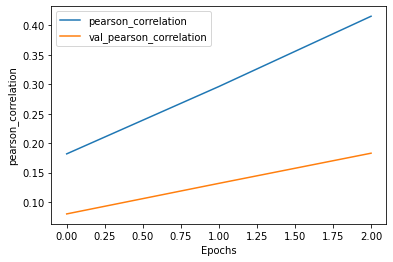

In [21]:
plot_graphs(history, 'pearson_correlation')

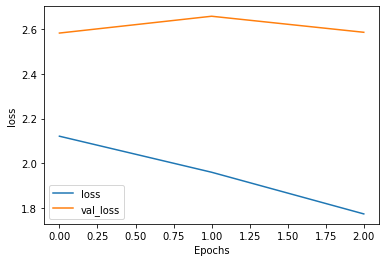

In [22]:
plot_graphs(history, 'loss')

# KorSTSTEST

In [23]:
# Load Test dataset
TEST_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-test.tsv')

test_data = pd.read_csv(TEST_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,main-captions,MSRvid,2012test,45,5.0,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,main-captions,MSRvid,2012test,63,4.2,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,main-captions,MSRvid,2012test,66,1.5,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.


In [24]:
test_data_sents1 = []
test_data_sents2 = []
test_labels = []


for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    test_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    test_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]] 
    tokens1 += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.sep_token]]  
    tokens1 += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]] 
    tokens2 += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.sep_token]]  
    tokens2 += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.eos_token]]
    
    test_data_sents1.append(tokens1)
    test_data_sents2.append(tokens2)
    test_labels.append(score)

test_data_sents1 = np.array(test_data_sents1, dtype=np.int64)
test_data_sents2 = np.array(test_data_sents2, dtype=np.int64)
test_data_sents = (test_data_sents1, test_data_sents2)
test_data_labels = np.array(test_labels)

In [25]:
print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 2, # labels: 1379


In [26]:
regression_model.save_weights("data_out/KOR/tf_gpt2_finetune_KorSTS/weights_STS.h5")

In [27]:
regression_model.load_weights("data_out/KOR/tf_gpt2_finetune_KorSTS/weights_STS.h5")

In [28]:
results = regression_model.evaluate(test_data_sents, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

3/3 [==============================] - 1s 434ms/step - loss: 2.2408 - pearson_correlation: 0.2542
test loss, test pearson correlation:  [2.2407796382904053, 0.2542467415332794]
